# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling_replacement(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
3796 1898 1898 126 63 64
3796 1898 1898 3796 1898 64
7592 3796 1962


### Separando entrada de saida

In [11]:
# columns = data_set.columns.tolist()
# shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
# rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 3796, 0.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.3759 - acc: 0.6470 - val_loss: 0.4021 - val_acc: 0.6502
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.2109 - acc: 0.7337 - val_loss: 0.1824 - val_acc: 0.8156
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1378 - acc: 0.8315 - val_loss: 0.1511 - val_acc: 0.8498
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1076 - acc: 0.8722 - val_loss: 0.1308 - val_acc: 0.8483
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0982 - acc: 0.8790 - val_loss: 0.1184 - val_acc: 0.8519
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0934 - acc: 0.8857 - val_loss: 0.1158 - val_acc: 0.8525
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0908 - acc: 0.8950 - val_loss: 0.1154 - val_acc: 0.8462
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9041 - val_loss: 0.0933 - val_acc: 0.8701
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9046 - val_loss: 0.0938 - val_acc: 0.8701
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9046 - val_loss: 0.0941 - val_acc: 0.8693
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9045 - val_loss: 0.0944 - val_acc: 0.8685
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9042 - val_loss: 0.0947 - val_acc: 0.86910
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9041 - val_loss: 0.0933 - val_acc: 0.8683
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9041 - val_loss: 0.0931 - val_acc: 0.8696
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9045 - val_loss: 0.0933 - val_a

7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9021 - val_loss: 0.0952 - val_acc: 0.8759
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9033 - val_loss: 0.0921 - val_acc: 0.8838
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9032 - val_loss: 0.0914 - val_acc: 0.8836
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9040 - val_loss: 0.0927 - val_acc: 0.8849
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0741 - acc: 0.9029 - val_loss: 0.0947 - val_acc: 0.8693
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0741 - acc: 0.9041 - val_loss: 0.0930 - val_acc: 0.8817
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9037 - val_loss: 0.0934 - val_acc: 0.8772
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0740 - acc: 0.9029 - val_loss: 0.0932 -

7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9035 - val_loss: 0.0951 - val_acc: 0.8749
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9027 - val_loss: 0.0959 - val_acc: 0.8606
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9027 - val_loss: 0.0959 - val_acc: 0.8609
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9037 - val_loss: 0.0961 - val_acc: 0.8609
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.0956 - val_acc: 0.8751
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9027 - val_loss: 0.0959 - val_acc: 0.8599
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9028 - val_loss: 0.0973 - val_acc: 0.8609
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9036 - val_loss: 0.0980 -

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9029 - val_loss: 0.0987 - val_acc: 0.8601
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0965 - val_acc: 0.8678
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9027 - val_loss: 0.0970 - val_acc: 0.8675
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.0956 - val_acc: 0.8683
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9024 - val_loss: 0.0977 - val_acc: 0.8596
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.0973 - val_acc: 0.8693
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0984 - val_acc: 0.8599
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.0970 -

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9042 - val_loss: 0.1027 - val_acc: 0.8606
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0995 - val_acc: 0.8617
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9037 - val_loss: 0.0980 - val_acc: 0.8685
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.1008 - val_acc: 0.8612
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9029 - val_loss: 0.0991 - val_acc: 0.8583
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9041 - val_loss: 0.0996 - val_acc: 0.8591
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9021 - val_loss: 0.0986 - val_acc: 0.8675
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9040 - val_loss: 0.0988 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0969 - val_acc: 0.8741
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9040 - val_loss: 0.1033 - val_acc: 0.8617
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9038 - val_loss: 0.0974 - val_acc: 0.8691
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0995 - val_acc: 0.8606
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9029 - val_loss: 0.0996 - val_acc: 0.8675
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9035 - val_loss: 0.0993 - val_acc: 0.8588
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.0989 - val_acc: 0.8591
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9033 - val_loss: 0.0992 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9048 - val_loss: 0.0983 - val_acc: 0.8738
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.0994 - val_acc: 0.8667
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1001 - val_acc: 0.8606
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0984 - val_acc: 0.8696
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0996 - val_acc: 0.8612
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.1004 - val_acc: 0.8617
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.0994 - val_acc: 0.8609
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.0987 -

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9040 - val_loss: 0.0990 - val_acc: 0.8588
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0980 - val_acc: 0.8670
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9025 - val_loss: 0.1012 - val_acc: 0.8596
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0998 - val_acc: 0.8593
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9027 - val_loss: 0.0987 - val_acc: 0.8685
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.1007 - val_acc: 0.8606
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9024 - val_loss: 0.0993 - val_acc: 0.8604
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0982 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0990 - val_acc: 0.8585
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9035 - val_loss: 0.0988 - val_acc: 0.8688
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9037 - val_loss: 0.0975 - val_acc: 0.8738
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0995 - val_acc: 0.8599
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0994 - val_acc: 0.8612
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9049 - val_loss: 0.0983 - val_acc: 0.8675
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9041 - val_loss: 0.0983 - val_acc: 0.8672
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0989 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.0991 - val_acc: 0.8606
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9046 - val_loss: 0.0993 - val_acc: 0.8596
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9031 - val_loss: 0.0984 - val_acc: 0.8691
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1002 - val_acc: 0.8620
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9038 - val_loss: 0.0991 - val_acc: 0.8691
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0977 - val_acc: 0.8688
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1004 - val_acc: 0.8609
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.1006 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9031 - val_loss: 0.1003 - val_acc: 0.8612
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.0995 - val_acc: 0.8609
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9029 - val_loss: 0.1002 - val_acc: 0.8612
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9048 - val_loss: 0.1002 - val_acc: 0.8606
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.1009 - val_acc: 0.8604
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0995 - val_acc: 0.8693
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.0996 - val_acc: 0.8601
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9042 - val_loss: 0.1001 -

7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9035 - val_loss: 0.0980 - val_acc: 0.8675
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.1001 - val_acc: 0.8599
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.0983 - val_acc: 0.8670
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9029 - val_loss: 0.0992 - val_acc: 0.8601
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9054 - val_loss: 0.0983 - val_acc: 0.8672
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0.1004 - val_acc: 0.8614
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.1002 - val_acc: 0.8612
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.0998 -

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9033 - val_loss: 0.1004 - val_acc: 0.8599
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1009 - val_acc: 0.8596
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.1014 - val_acc: 0.8596
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9053 - val_loss: 0.0985 - val_acc: 0.8664
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.1003 - val_acc: 0.8614
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0994 - val_acc: 0.8591
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9028 - val_loss: 0.1008 - val_acc: 0.8612
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1010 -

7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9044 - val_loss: 0.0989 - val_acc: 0.8601
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1018 - val_acc: 0.8622
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0.0981 - val_acc: 0.8664
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0984 - val_acc: 0.8693
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9049 - val_loss: 0.0978 - val_acc: 0.8678
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0997 - val_acc: 0.8601
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.1021 - val_acc: 0.8625
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0.0988 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9036 - val_loss: 0.0983 - val_acc: 0.8667
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.0983 - val_acc: 0.8667
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9050 - val_loss: 0.1013 - val_acc: 0.8606
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.1008 - val_acc: 0.8596
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.1026 - val_acc: 0.8612
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.0980 - val_acc: 0.8670
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9028 - val_loss: 0.0990 - val_acc: 0.8678
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0.1013 -

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9050 - val_loss: 0.0993 - val_acc: 0.8614
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0996 - val_acc: 0.8617
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9036 - val_loss: 0.1023 - val_acc: 0.8601
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.0998 - val_acc: 0.8614
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9050 - val_loss: 0.0996 - val_acc: 0.8588
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9035 - val_loss: 0.0977 - val_acc: 0.8670
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9042 - val_loss: 0.0983 - val_acc: 0.8664
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9049 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9038 - val_loss: 0.0985 - val_acc: 0.8683
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9048 - val_loss: 0.0993 - val_acc: 0.8593
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.0987 - val_acc: 0.8591
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9056 - val_loss: 0.0995 - val_acc: 0.8606
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9060 - val_loss: 0.1014 - val_acc: 0.8628
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9049 - val_loss: 0.0999 - val_acc: 0.8609
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9031 - val_loss: 0.0978 - val_acc: 0.8670
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0739 - acc: 0.9037 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9037 - val_loss: 0.0987 - val_acc: 0.8691
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9036 - val_loss: 0.0994 - val_acc: 0.8612
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9042 - val_loss: 0.0982 - val_acc: 0.8688
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9050 - val_loss: 0.0987 - val_acc: 0.8685
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0988 - val_acc: 0.8599
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9036 - val_loss: 0.1009 - val_acc: 0.8601
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1012 - val_acc: 0.8630
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9046 - val_loss: 0.0979 - val_acc: 0.8688
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.0987 - val_acc: 0.8680
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0997 - val_acc: 0.8609
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9056 - val_loss: 0.1007 - val_acc: 0.8606
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9033 - val_loss: 0.1003 - val_acc: 0.8599
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1025 - val_acc: 0.8612
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0986 - val_acc: 0.8683
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9052 - val_loss: 0.0994 - val_acc: 0.8614
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0983 - val_acc: 0.8688
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9029 - val_loss: 0.1004 - val_acc: 0.8601
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1005 - val_acc: 0.8625
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0998 - val_acc: 0.8583
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9045 - val_loss: 0.1004 - val_acc: 0.8630
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1004 - val_acc: 0.8606
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9027 - val_loss: 0.0997 - val_acc: 0.8599
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9045 - val_loss: 0.1007 - val_acc: 0.8606
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9048 - val_loss: 0.0992 - val_acc: 0.8606
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0995 - val_acc: 0.8588
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9048 - val_loss: 0.0987 - val_acc: 0.8662
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9037 - val_loss: 0.1028 - val_acc: 0.8606
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0995 - val_acc: 0.8593
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9036 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.0999 - val_acc: 0.8601
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9024 - val_loss: 0.0996 - val_acc: 0.8583
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9036 - val_loss: 0.0982 - val_acc: 0.8733
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9041 - val_loss: 0.1007 - val_acc: 0.8622
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0996 - val_acc: 0.8617
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9049 - val_loss: 0.0997 - val_acc: 0.8614
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1003 - val_acc: 0.8614
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9050 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0991 - val_acc: 0.8604
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0991 - val_acc: 0.8696
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9045 - val_loss: 0.1002 - val_acc: 0.8604
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0985 - val_acc: 0.8672
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9042 - val_loss: 0.0998 - val_acc: 0.8601
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0990 - val_acc: 0.8659
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0993 - val_acc: 0.8606
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0991 - val_acc: 0.8675
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9025 - val_loss: 0.0987 - val_acc: 0.8691
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9041 - val_loss: 0.0987 - val_acc: 0.8596
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9041 - val_loss: 0.1005 - val_acc: 0.8620
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0991 - val_acc: 0.8591
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.1009 - val_acc: 0.8593
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9052 - val_loss: 0.0987 - val_acc: 0.8662
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9036 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0988 - val_acc: 0.8685
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.0993 - val_acc: 0.8609
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.1016 - val_acc: 0.8612
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1008 - val_acc: 0.8606
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9040 - val_loss: 0.1018 - val_acc: 0.8612
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.0992 - val_acc: 0.8591
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9041 - val_loss: 0.0989 - val_acc: 0.8612
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9041 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9038 - val_loss: 0.1013 - val_acc: 0.8630
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.0994 - val_acc: 0.8614
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9032 - val_loss: 0.1006 - val_acc: 0.8606
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1000 - val_acc: 0.8606
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9046 - val_loss: 0.1012 - val_acc: 0.8625
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9052 - val_loss: 0.1010 - val_acc: 0.8596
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1012 - val_acc: 0.8622
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9036 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9054 - val_loss: 0.0994 - val_acc: 0.8606
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9045 - val_loss: 0.0983 - val_acc: 0.8675
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9046 - val_loss: 0.0994 - val_acc: 0.8612
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9035 - val_loss: 0.1016 - val_acc: 0.8614
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9050 - val_loss: 0.0986 - val_acc: 0.8680
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9033 - val_loss: 0.1002 - val_acc: 0.8604
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9053 - val_loss: 0.1007 - val_acc: 0.8609
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9048 - val_loss: 0.0993 - val_acc: 0.8609
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9044 - val_loss: 0.1002 - val_acc: 0.8612
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9032 - val_loss: 0.0997 - val_acc: 0.8599
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9038 - val_loss: 0.0982 - val_acc: 0.8699
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0.0976 - val_acc: 0.8672
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9045 - val_loss: 0.0996 - val_acc: 0.8599
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9042 - val_loss: 0.1004 - val_acc: 0.8604
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9050 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.0984 - val_acc: 0.8672
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9027 - val_loss: 0.1040 - val_acc: 0.8617
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9031 - val_loss: 0.0991 - val_acc: 0.8693
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9046 - val_loss: 0.0992 - val_acc: 0.8606
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9045 - val_loss: 0.1001 - val_acc: 0.8601
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9036 - val_loss: 0.0982 - val_acc: 0.8691
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9037 - val_loss: 0.1015 - val_acc: 0.8625
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9038 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9058 - val_loss: 0.0990 - val_acc: 0.8678
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9046 - val_loss: 0.1008 - val_acc: 0.8596
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1000 - val_acc: 0.8612
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9046 - val_loss: 0.1003 - val_acc: 0.8659
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1002 - val_acc: 0.8591
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0.1000 - val_acc: 0.8599
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9031 - val_loss: 0.0990 - val_acc: 0.8678
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0736 - acc: 0.9042 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9044 - val_loss: 0.0984 - val_acc: 0.8685
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9028 - val_loss: 0.0991 - val_acc: 0.8601
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9035 - val_loss: 0.1005 - val_acc: 0.8628
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9029 - val_loss: 0.0981 - val_acc: 0.8672
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9044 - val_loss: 0.0986 - val_acc: 0.8691
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9040 - val_loss: 0.0996 - val_acc: 0.8606
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0738 - acc: 0.9050 - val_loss: 0.1017 - val_acc: 0.8614
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9040 - val_loss: 0

In [16]:
classifier.evaluate(X_test, y_test)
# print (test_loss)

1216/1962 [=================>............] - ETA: 0s

[0.057721121891740633, 0.91539245673761938]

<IPython.core.display.Javascript object>


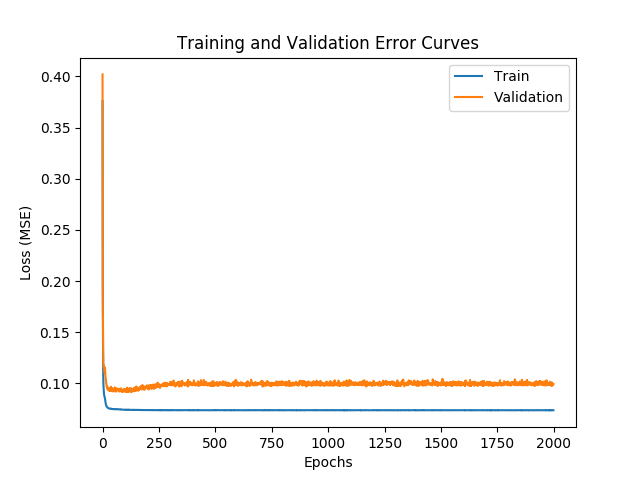

<IPython.core.display.Javascript object>


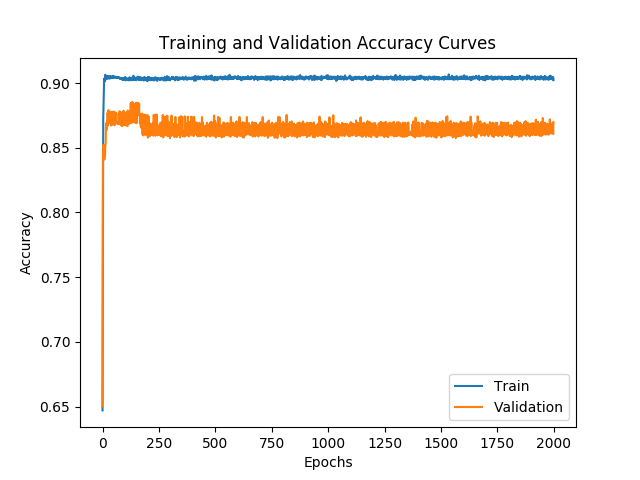

In [17]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 2 (5)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1778 - acc: 0.7983 - val_loss: 0.1947 - val_acc: 0.8164
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.1279 - acc: 0.8538 - val_loss: 0.1848 - val_acc: 0.8385
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.1103 - acc: 0.8720 - val_loss: 0.1582 - val_acc: 0.8722
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1005 - acc: 0.8875 - val_loss: 0.1398 - val_acc: 0.8712
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0954 - acc: 0.8882 - val_loss: 0.1288 - val_acc: 0.8659
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0925 - acc: 0.8853 - val_loss: 0.1214 - val_acc: 0.8722
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0902 - acc: 0.8878 - val_loss: 0.1178 - val_acc: 0.8683
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0658 - acc: 0.9253 - val_loss: 0.1063 - val_acc: 0.8786
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0657 - acc: 0.9241 - val_loss: 0.1068 - val_acc: 0.8759
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0658 - acc: 0.9247 - val_loss: 0.1077 - val_acc: 0.8793
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0657 - acc: 0.9247 - val_loss: 0.1071 - val_acc: 0.8780
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0657 - acc: 0.9247 - val_loss: 0.1075 - val_acc: 0.8683
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0657 - acc: 0.9239 - val_loss: 0.1073 - val_acc: 0.8678
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0656 - acc: 0.9251 - val_loss: 0.1077 - val_acc: 0.8791
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0656 - acc: 0.9252 - val_loss: 0.1080 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9258 - val_loss: 0.1093 - val_acc: 0.8688
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9254 - val_loss: 0.1081 - val_acc: 0.8683
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9261 - val_loss: 0.1105 - val_acc: 0.8714
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9261 - val_loss: 0.1085 - val_acc: 0.8683
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9256 - val_loss: 0.1099 - val_acc: 0.8699
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9260 - val_loss: 0.1102 - val_acc: 0.8691
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9261 - val_loss: 0.1103 - val_acc: 0.8685
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9261 - val_loss: 0.1104 -

7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9264 - val_loss: 0.1137 - val_acc: 0.8704
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9264 - val_loss: 0.1124 - val_acc: 0.8691
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9264 - val_loss: 0.1127 - val_acc: 0.8696
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9260 - val_loss: 0.1127 - val_acc: 0.8707
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9268 - val_loss: 0.1128 - val_acc: 0.8693
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9257 - val_loss: 0.1138 - val_acc: 0.8709
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9256 - val_loss: 0.1140 - val_acc: 0.8696
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9264 - val_loss: 0.1135 -

7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9261 - val_loss: 0.1139 - val_acc: 0.8688
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9264 - val_loss: 0.1139 - val_acc: 0.8704
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9266 - val_loss: 0.1132 - val_acc: 0.8670
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9260 - val_loss: 0.1140 - val_acc: 0.8685
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9264 - val_loss: 0.1132 - val_acc: 0.8704
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9264 - val_loss: 0.1129 - val_acc: 0.8683
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9262 - val_loss: 0.1137 - val_acc: 0.8701
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9269 - val_loss: 0.1136 -

KeyboardInterrupt: 

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 3 (3, 5)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 4 (5,3)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 5 (2)

In [ ]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
